# Gaussian Scale Mixture model


- Orbán, Gergő, Pietro Berkes, József Fiser, and Máté Lengyel. 2016. “Neural Variability and Sampling-Based Probabilistic Representations in the Visual Cortex.” Neuron 92 (2): 530–43.
- Echeveste, Rodrigo, Laurence Aitchison, Guillaume Hennequin, and Máté Lengyel. 2020. “Cortical-like Dynamics in Recurrent Circuits Optimized for Sampling-Based Probabilistic Inference.” Nature Neuroscience 23 (9): 1138–49.
- Echeveste, Rodrigo, Guillaume Hennequin, and Máté Lengyel. 2017. “Asymptotic Scaling Properties of the Posterior Mean and Variance in the Gaussian Scale Mixture Model.” arXiv [q-bio.QM]. arXiv. https://doi.org/10.48550/ARXIV.1706.00925.

$$
\mathrm{P}\left(\mathbf{x}\mid\mathbf{y}, z\right)=\mathcal{N}\left(z \mathbf{A} \mathbf{y}, \sigma_{\mathbf{x}}^{2} \mathbf{I}\right)
$$

$$
\mathrm{P}\left(\mathbf{y}\right)=\mathcal{N}\left(\mathbf{0}, \mathbf{C}\right)
$$

$$
\begin{aligned}
\mathrm{P}(z \mid \mathbf{x}) &\propto \mathrm{P}(z) \mathcal{N}\left(0, z^{2} \mathbf{A C A}^{\top}+\sigma_{x}^{2} \mathbf{I}\right) \\
\mathrm{P}(\mathbf{y} \mid z, \mathbf{x})&=\mathcal{N}(\mu(z, \mathbf{x}), \Sigma(z))
\end{aligned}
$$

In [1]:
using Base: @kwdef
using Parameters: @unpack
using PyPlot, LinearAlgebra, Random, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
using NPZ

In [ ]:
function gabor_fn(sigma, theta, Lambda, psi, gamma, L)
    sigma_x = sigma
    sigma_y = sigma / gamma

    # Image
    n_sigmas = 3
    
    xmax = sigma * n_sigmas
    ymax = sigma * n_sigmas
    xmin = -xmax
    ymin = -ymax
    x_ticks = linspace(xmin, xmax, L)
    y_ticks = linspace(ymin, ymax, L)
    
    x, y = meshgrid(x_ticks, y_ticks)
    # Rotation 
    x_theta = x * cos(theta) + y * sin(theta)
    y_theta = -x * sin(theta) + y * cos(theta)
    
    gb = exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * cos(2 * pi / Lambda * x_theta + psi)
    
    #gb = cos(2 * pi / Lambda * x_theta + psi) # Full field
    gb = gb / linalg.norm(gb)
    return gb
end

In [ ]:
sigma = 1.0
theta = np.pi*0.25
Lambda = 2.0*sigma
psi = 0.0
gamma = 1.0
n_pat = 50
L = 16    

gb = np.empty([n_pat,L,L])

for i in 1:n_pat
    theta = np.pi*i/(1.0*n_pat)
    gb[i]= gabor_fn(sigma, theta, Lambda, psi, gamma, L)
end

フーリエ基底から入力を作成して共分散行列を作る．

In [3]:
# Produces a matrix whose columns are a set of discreete fourier base vectors        
# まだ
function get_fourier_base(m)
    base = zeros(m, m)
    L = 2*pi/(1.0*m)
    
    for j in 1:m
        f = j//2
        if (j%2 == 0)
            for i in 1:m
                base[j][i] = cos(L*f*i)
            end
        else
            for i in 1:m
                base[j][i] = sin(L*f*i)
            end
        end
        norm = linalg.norm(base[j])
        if (norm != 0)
            base[j] = base[j]/norm
        end
    end
    return base'
end;

In [4]:
# Create an input covariance C with the right symmetry from the fourier base
# まだ
function get_C_from_fourier(epsilon, base, decay_length)
    m = length(base)
    C = epsilon * Matrix{Float64}(I, m, m) # Regularizer
    for i in 1:m
        v = base[:,i]
        lbda = 20*exp(-(1.0*(i//2))/decay_length)
        C = C + lbda * v * v'
    end
    C = C - 0.25    
    C =  C * (4.0 / C[1,1])
    return C
end

get_C_from_fourier (generic function with 1 method)

In [5]:
C = npzread("C.npy");
A = npzread("filters.npy");

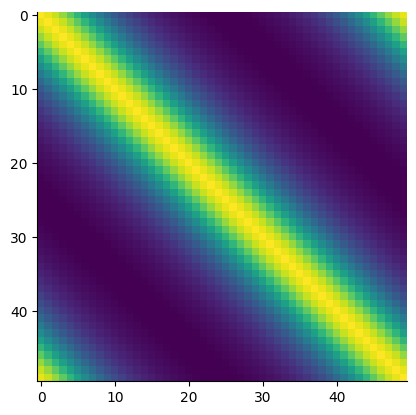

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\yamta\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


PyObject <matplotlib.image.AxesImage object at 0x0000000065401A90>

In [6]:
imshow(C)

In [7]:
size(A)

(256, 50)

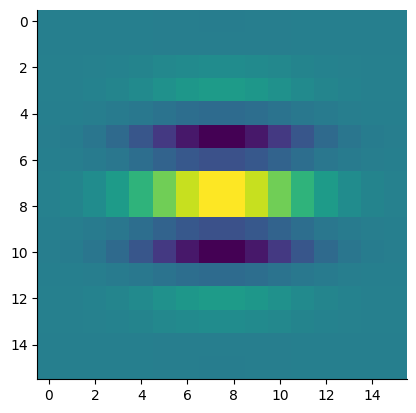

PyObject <matplotlib.image.AxesImage object at 0x0000000095B4BB20>

In [8]:
imshow(reshape(A[:, 1], 16,16))

Get x from y and z

$x$を取得する関数を記述する．

In [9]:
function get_x(y, z, A, σx)
    x_mean = z*A*y
    noise = σx * randn(size(x_mean))
    return x_mean + noise
end

get_μz(z, σx_2, Σ_post, A, x) = (z/σx_2) * Σ_post * A' * x
get_Σz(z, σx_2, C_inv, ATA) = inv(C_inv + (z^2 / σx_2) * ATA)

function get_post_moments(x, z_MAP, σx_2, A, ATA, C_inv)
    Σ = get_Σz(z_MAP, σx_2, C_inv, ATA)
    μ = get_μz(z_MAP, σx_2, Σ, A, x)
    return μ, Σ
end

get_post_moments (generic function with 1 method)

In [10]:
log_P_z(z, k, θ) = logpdf.(Gamma(k, θ), z);

In [11]:
function P_z_giv_x(z_range, x, ACAT, σx_2, k, θ)
    n_contrasts = length(z_range)
    D_x = length(x)
    log_p = zeros(n_contrasts)
    x_mean = zeros(D_x)
    dz = z_range[2] - z_range[1]
    for i in 1:n_contrasts
        Cov = z_range[i]^2 * ACAT + σx_2 * Matrix{Float64}(I, D_x, D_x)
        log_p[i] = log_P_z(z_range[i], k, θ) + logpdf(MvNormal(x_mean, Symmetric(Cov)), x)
    end
    p = exp.(log_p .- maximum(log_p))
    p /= sum(p) * dz
    return p   
end

P_z_giv_x (generic function with 1 method)

## Main

In [12]:
# We first import the filters, since this determines the dimensionality
ATA = A' * A
D_x, D_y = size(A) # Dimensionality of the observed variable x & the hidden variable y

16

In [13]:
"""
# We create the basis matrix B
B = get_fourier_base(D_y)

# We build C from B
decay_length = D_y / 50.0 # for the eigenvalues of C
epsilon = 0.01 # regularizer for C
C = get_C_from_fourier(epsilon,B, decay_length)
"""
d = 0.0 * sqrt(C[1,1]) # average mean of y in units of sd's 

ACAT = A * C * A'

# We generate the dataset
n_targets = 6            # Num of points in the dataset (or total observation time)

# Dist params
σx = 1.0                # Noise of the x process
σx_2 = σx^2
k, θ = 2.0, 2.0                   # Parameter of the gamma dist. for z. (Shape, Scale)

# Mean and covariance of y
y_mean = zeros(D_y)            # The mean is 0 for y

# We will need the inverse of C
C_inv = inv(C);

入力データの作成

In [14]:
x_array = zeros(n_targets, D_x)
y_array = zeros(n_targets, D_y)
z_array = [0.0,　0.125,　0.25,　0.5,　1.0,　2.0];

y_sample = rand(MvNormal(y_mean, Symmetric(C)), 1)
for alpha in 1:n_targets
    y_array[alpha, :] = y_sample
end

for alpha in 1:n_targets
    x_array[alpha, :] = get_x(y_array[alpha, :], z_array[alpha], A, σx)
end

`Symmetric(Cov)` or `Matrix(Hermitian(Cov)))`

In [40]:
# We compute the moments of the posteriors
μ_post = zeros(n_targets, D_y)
Σ_post = zeros(n_targets, D_y, D_y)
std_post = zeros(n_targets, D_y)

z_min, z_max = 0, 5.0
n_points = 100
z_range = range(z_min, z_max, length=n_points)
z_MAP_array = zeros(n_targets)

for alpha in 1:n_targets
    p_z = P_z_giv_x(z_range, x_array[alpha, :], ACAT, σx_2, k, θ)

    # Moments at MAP contrast
    z_MAP_array[alpha] = z_range[argmax(p_z)]
    μ_post[alpha, :], Σ_post[alpha, :, :] = get_post_moments(
                                            x_array[alpha, :], z_MAP_array[alpha], σx_2,A,ATA,C_inv)
    std_post[alpha, :] = sqrt.(diag(Σ_post[alpha, :, :]))
end

## 結果
#### 入力

`z_array`が入力作成時に使われたもの．

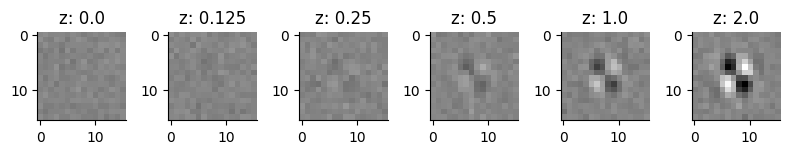

In [41]:
x_min, x_max = minimum(x_array), maximum(x_array)

figure(figsize=(8,2))
for alpha in 1:n_targets
    subplot(1, n_targets ,alpha)
    title("z: "*string(z_array[alpha]))
    imshow(reshape(x_array[alpha, :], 16, 16), 
        vmin=x_min, vmax=x_max, cmap="gray")
end
tight_layout()

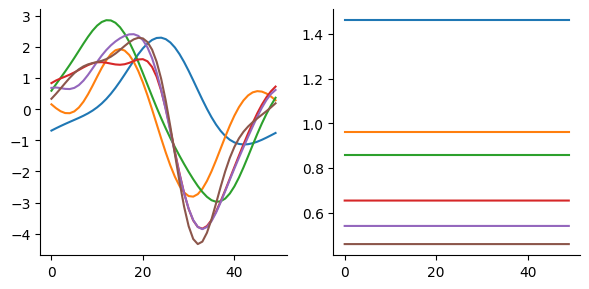

In [42]:
figure(figsize=(6,3))
subplot(1,2,1)
for alpha in 1:n_targets
    plot(μ_post[alpha, :])
end
subplot(1,2,2)
for alpha in 1:n_targets
    plot(std_post[alpha, :])
end
tight_layout()

#### $\Sigma$

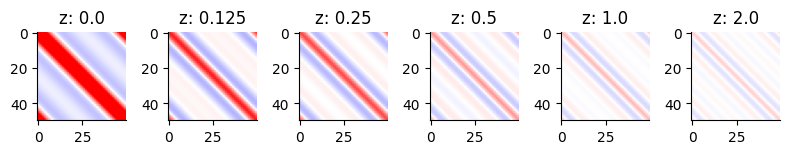

In [43]:
figure(figsize=(8,2))
for alpha in 1:n_targets
    subplot(1,n_targets,alpha)
    title("z: "*string(z_array[alpha]))
    imshow(Σ_post[alpha, :, :],
               vmin=-1, vmax=1,cmap="bwr")
end
tight_layout()

### output

In [36]:
"""
uTh = 1.9
thGam = 2
sigmaX = 0.7945
m = 10
alpha = 1.4
beta = 1.1
"""

"uTh = 1.9\nthGam = 2\nsigmaX = 0.7945\nm = 10\nalpha = 1.4\nbeta = 1.1\n"

In [37]:
membrane_potential(y, alpha=1.4) = sign(y) * abs(y)^alpha

membrane_potential (generic function with 2 methods)

In [21]:
firing_rate(u, beta=1.1, m=10, uTh=1.9) = m * max.(0, u-uTh)^beta

firing_rate (generic function with 4 methods)

In [44]:
nt = 100
u = zeros(n_targets, D_y, nt)
for alpha in 1:n_targets
    μ = μ_post[alpha, :]
    Σ = Σ_post[alpha, :, :]
    d = MvNormal(μ, Symmetric(Σ))
    sample = rand(d, nt)
    u[alpha, :, :] = membrane_potential.(sample)
end

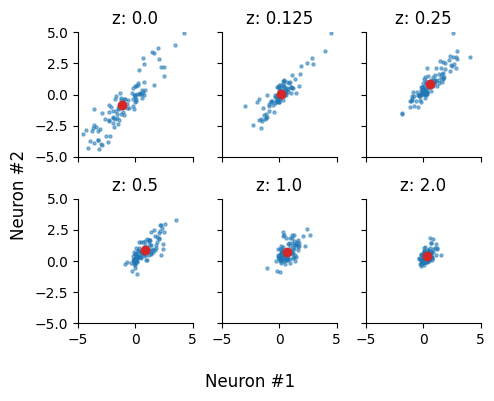

In [45]:
fig, ax = subplots(2, 3, figsize=(5, 4), sharex="all", sharey="all")#, dpi=300)
for i in 1:2
    for j in 1:3
        alpha = (i-1)*3 + j
        ax[i, j].set_title("z: "*string(z_array[alpha]))
        #ax[i, j].plot(u[alpha, 1, :], u[alpha, 2, :], alpha=0.5, marker="o")
        ax[i, j].scatter(u[alpha, 1, :], u[alpha, 2, :], alpha=0.5, s=5)
        ax[i, j].scatter(mean(u[alpha, 1, :]), mean(u[alpha, 2, :]), color="tab:red")
        ax[i, j].set_xlim(-5,5)
        ax[i, j].set_ylim(-5,5)
    end
end
fig.supxlabel("Neuron #1")
fig.supylabel("Neuron #2")
tight_layout()